In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Retrieve chart from TV

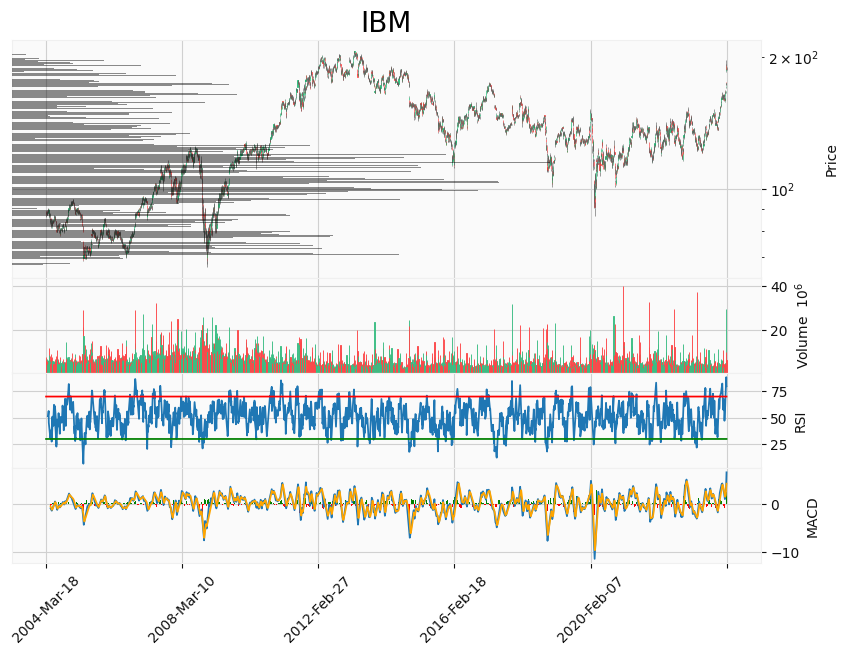

In [10]:
from stockMarket.core import Technicals

contract = Technicals(ticker="IBM")
contract.init_pricing_data(n_bars=5000)
rsi = contract.rsi()
macd = contract.macd()
contract.plot(rsi=rsi, macd=macd, logarithmic_scale="log")

you are using nologin method, data you access may be limited


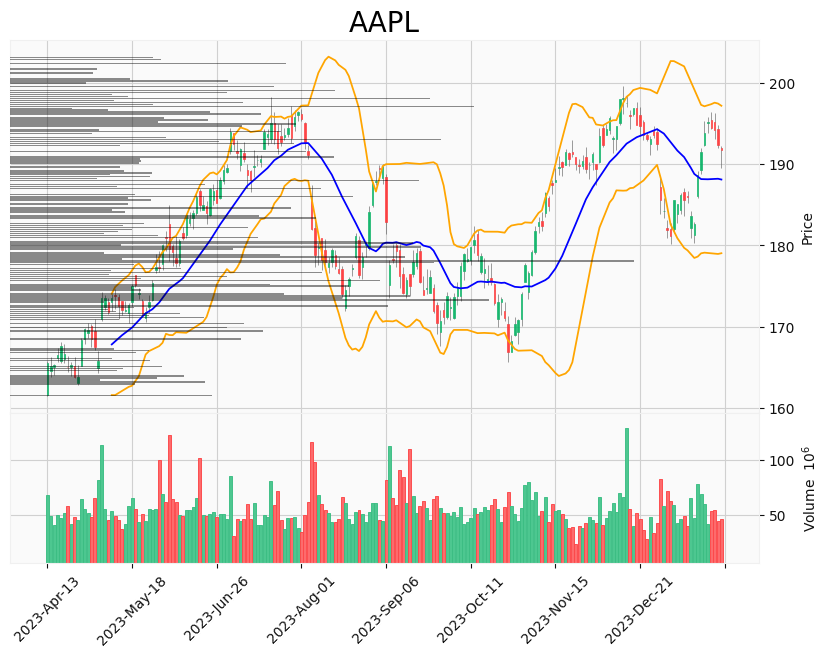

In [4]:
from stockMarket.core import Technicals

contract = Technicals(ticker="AAPL")
contract.init_pricing_data(interval="daily", n_bars=200)
bbands = contract.bbands()
contract.plot(bbands=bbands)



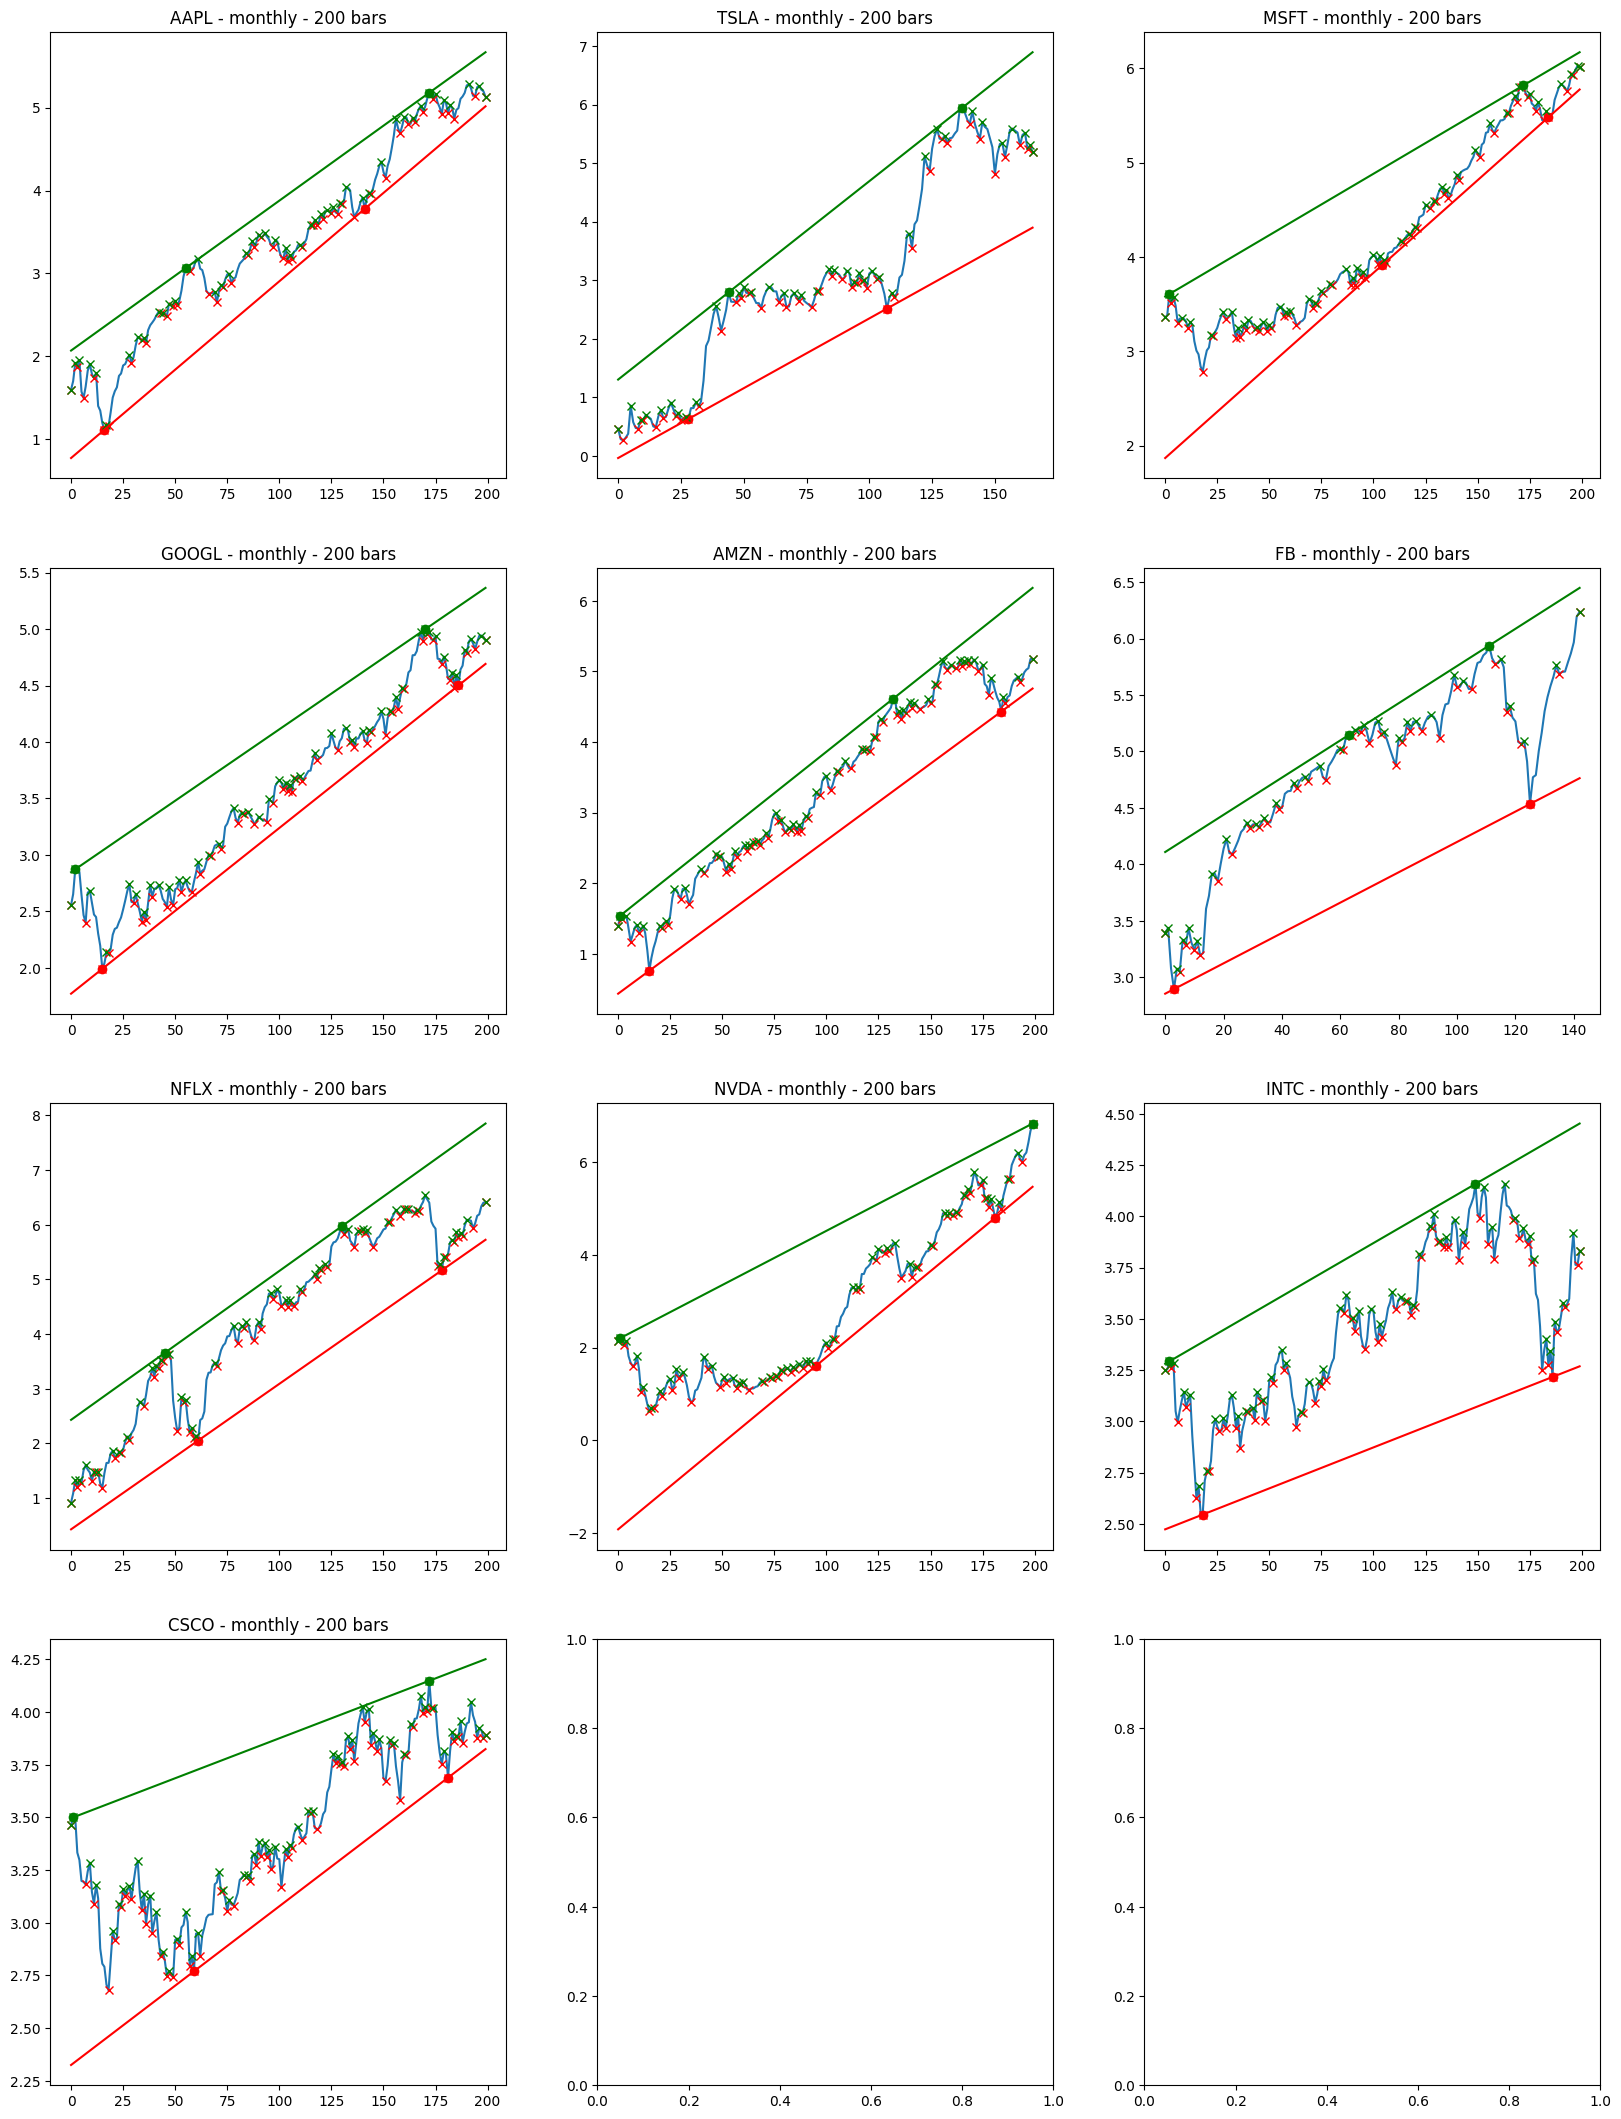

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import argrelextrema
from matplotlib.ticker import FixedLocator

from stockMarket.core import Technicals

def get_extrema(log_close, mode=np.less):
    index_extrema = argrelextrema(log_close, mode)[0]
    index_extrema = [0] + list(index_extrema) + [len(log_close)-1]
    extrema_pairs = []
    for i in range(len(index_extrema)):
        index_i = index_extrema[i]
        price_i = log_close[index_i]
        for j in range(i+1, len(index_extrema)):
            index_j = index_extrema[j]
            price_j = log_close[index_j]
            
            k = (price_j - price_i) / (index_j - index_i)
            intercept = price_i - k * index_i
            discarded_prices = []
            for index in range(len(log_close)):
                price = log_close[index]
                factor = 0.98 if mode == np.less else 1.02
                if mode(np.exp(price), np.exp((k * index + intercept)) * factor):
                    discarded_prices.append(price)
            if len(discarded_prices) == 0:
                extrema_pairs.append((index_i, index_j))
                
    return extrema_pairs, index_extrema

tickers = ["AAPL", "TSLA", "MSFT", "GOOGL", "AMZN", "FB", "NFLX", "NVDA", "INTC", "CSCO"]
# tickers = ["AAPL"]

n_rows = int(np.ceil(len(tickers) / 3))
size_x = 20
size_y = 20 / 3 * n_rows

fig, ax = plt.subplots(n_rows, 3, figsize=(size_x, size_y))

for n_ticker, ticker in enumerate(tickers):
    candle_size = "monthly"
    number_of_bars = 200
    contract = Technicals(ticker=ticker)
    contract.init_pricing_data(interval=candle_size, n_bars=number_of_bars)
    log_close = np.log(contract.pricing_data.close.values)

    minima_pairs, index_minima = get_extrema(log_close, mode=np.less)
    maxima_pairs, index_maxima = get_extrema(log_close, mode=np.greater)
            
    best_minimum_pair = sorted(minima_pairs, key=lambda x: x[1] - x[0], reverse=True)[0] if len(minima_pairs) > 0 else []
    best_maximum_pair = sorted(maxima_pairs, key=lambda x: x[1] - x[0], reverse=True)[0] if len(maxima_pairs) > 0 else []
    
    ax_x = n_ticker // 3
    ax_y = n_ticker % 3
    
    if len(tickers) <= 3:
        my_ax = ax[ax_y]
    else:
        my_ax = ax[ax_x,ax_y]
    
    # ax[ax_x,ax_y].set_yscale('log')
    # min_close = np.exp(log_close.min())
    # max_close = np.exp(log_close.max())
    # delta = max_close - min_close
    # ax[ax_x,ax_y].set_yticks([log_close[i] for i in range(0, len(log_close), 5)], [f"{np.exp(log_close[i]):.0f}" for i in range(0, len(log_close), 5)])
    my_ax.set_title(f"{ticker} - {candle_size} - {number_of_bars} bars")

    my_ax.plot(log_close)
        
    def func_trendline(x, slope, intercept):
        return slope * x + intercept
    
    for index in index_minima:
        my_ax.plot(index, log_close[index], 'rx')
        
    for index in best_minimum_pair:
        my_ax.plot(index, log_close[index], 'ro')
        
    for index in index_maxima:
        my_ax.plot(index, log_close[index], 'gx')
        
    for index in best_maximum_pair:
        my_ax.plot(index, log_close[index], 'go')
        
    if len(best_minimum_pair) > 0:
        k = (log_close[best_minimum_pair[1]] - log_close[best_minimum_pair[0]]) / (best_minimum_pair[1] - best_minimum_pair[0])
        intercept = log_close[best_minimum_pair[0]] - k * best_minimum_pair[0]
        trendline = [func_trendline(i, k, intercept) for i in range(len(log_close))]
        my_ax.plot(trendline, 'r-')
    
    if len(best_maximum_pair) > 0:
        k = (log_close[best_maximum_pair[1]] - log_close[best_maximum_pair[0]]) / (best_maximum_pair[1] - best_maximum_pair[0])
        intercept = log_close[best_maximum_pair[0]] - k * best_maximum_pair[0]
        trendline = [func_trendline(i, k, intercept) for i in range(len(log_close))]
        my_ax.plot(trendline, 'g-')
        